# PW2 - VAE for MNIST clustering and generation

In this practical, we will explore Variational Auto-Encoders (VAE) with the MNIST digit recognition dataset.
The purpose of a VAE is to generate new samples "looking like" the training samples.
For this purpose, we will construct a two-block model: encoder and decoder, one takes a sample and maps it to a latent space, the second takes a latent point and maps it to the sample space. If the latent distribution is roughly gaussian, this gives a way to get new samples: take a latent point at random,
and map it to the sample space with the decoder.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

from sklearn.metrics.cluster import normalized_mutual_info_score

In [3]:
N_CLASSES = 10
IMAGE_SIZE = 28 * 28

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [55]:
def show(img):
    plt.imshow(np.transpose(img.numpy(), (1,2,0)), interpolation='nearest')

def plot_reconstruction(model, n=24):
    x, labels = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    labels = labels[:n].to(device)
    l_onehot = l_2_onehot(labels).to(device)

    try:
        out, _, _, log_p = model(x.view(-1, IMAGE_SIZE), y_onehot=l_onehot)
    except:
        out, _, _ = model(x.view(-1, IMAGE_SIZE), y_onehot=l_onehot)

    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)

@torch.no_grad()
def plot_generation(model, n=24):
    z = torch.randn(n, z_dim).to(device)
    out = model.decode(z).view(-1, 1, 28, 28)
    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

@torch.no_grad()
def plot_conditional_generation(model, n=8, fix_number=None):
    matrix = np.zeros((n, N_CLASSES))
    matrix[:,0] = 1

    if fix_number is None:
        final = matrix[:]
        for i in range(1, N_CLASSES):
            final = np.vstack((final,np.roll(matrix,i)))
        z = torch.randn(n, z_dim)
        z = z.repeat(N_CLASSES,1).to(device)
        y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
        out = model.decode(z,y_onehot).view(-1, 1, 28, 28)
    else:
        z = torch.randn(n, z_dim).to(device)
        y_onehot = torch.tensor(np.roll(matrix, fix_number)).type(torch.FloatTensor).to(device)
        out = model.decode(z,y_onehot).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

@torch.no_grad()
def live_plot(data_dict, x_key=None, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label, data in data_dict.items():
        if label == x_key or len(data) == 0:
            continue
        x = data_dict[x_key] if x_key is not None else np.arange(len(data))
        plt.plot(x, data, label=label, linewidth=1)
    plt.title(title)
    plt.grid(alpha=.5, which='both')
    plt.xlabel('epoch' if x_key is None else x_key)
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

In [5]:
data_dir = './data'
dataset = torchvision.datasets.MNIST(
    root=data_dir,
    train=True,
    transform=transforms.ToTensor(),
    download=True)

data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=128,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

100.0%
100.0%
100.0%
100.0%


# Part A - Variational Autoencoders

## A.1 - Autoencoding theory

Consider a latent variable model with a data variable $x\in \mathcal{X}$ and a latent variable $z\in \mathcal{Z}$, $p(z,x) = p(z)p_\theta(x|z)$. Given the data $x_1,\dots, x_n$, we want to train the model by maximizing the marginal log-likelihood:
\begin{eqnarray*}
\mathcal{L} = \mathbf{E}_{p_d(x)}\left[\log p_\theta(x)\right]=\mathbf{E}_{p_d(x)}\left[\log \int_{\mathcal{Z}}p_{\theta}(x|z)p(z)dz\right],
  \end{eqnarray*}
  where $p_d$ denotes the empirical distribution of $X$: $p_d(x) =\frac{1}{n}\sum_{i=1}^n \delta_{x_i}(x)$.

 To avoid the (often) difficult computation of the integral above, the idea behind variational methods is to instead maximize a lower bound to the log-likelihood:
  \begin{eqnarray*}
\mathcal{L} \geq L(p_\theta(x|z),q(z|x)) =\mathbf{E}_{p_d(x)}\left[\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]-\mathrm{KL}\left( q(z|x)||p(z)\right)\right].
  \end{eqnarray*}
  Any choice of $q(z|x)$ gives a valid lower bound. Variational autoencoders replace the variational posterior $q(z|x)$ by an inference network $q_{\phi}(z|x)$ that is trained together with $p_{\theta}(x|z)$ to jointly maximize $L(p_\theta,q_\phi)$.
  
The variational posterior $q_{\phi}(z|x)$ is also called the **encoder** and the generative model $p_{\theta}(x|z)$, the **decoder** or generator.

The first term $\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]$ is the negative reconstruction error. Indeed under a gaussian assumption i.e. $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), I)$ the term $\log p_\theta(x|z)$ reduces to $\propto \|x-\mu_\theta(z)\|^2$, which is often used in practice. The term $\mathrm{KL}\left( q(z|x)||p(z)\right)$ can be seen as a regularization term, where the variational posterior $q_\phi(z|x)$ should be matched to the prior $p(z)= \mathcal{N}(0, I)$.

Variational Autoencoders were introduced by [Kingma and Welling (2013)](https://arxiv.org/abs/1312.6114), see also [(Doersch, 2016)](https://arxiv.org/abs/1606.05908) for a tutorial.

## A.2 - A simple autoencoder for MNIST

Implement the following autoencoder. 


![A variational autoencoder.](https://github.com/dataflowr/notebooks/blob/master/HW3/vae.png?raw=true)

Add a ReLU after FC1 and FC4


$\mu$ and $\log \sigma^2$ are used for reparametrization with
$z= \mu + \sigma \odot \epsilon$, where $\epsilon \sim \mathcal{N}(0,1)$

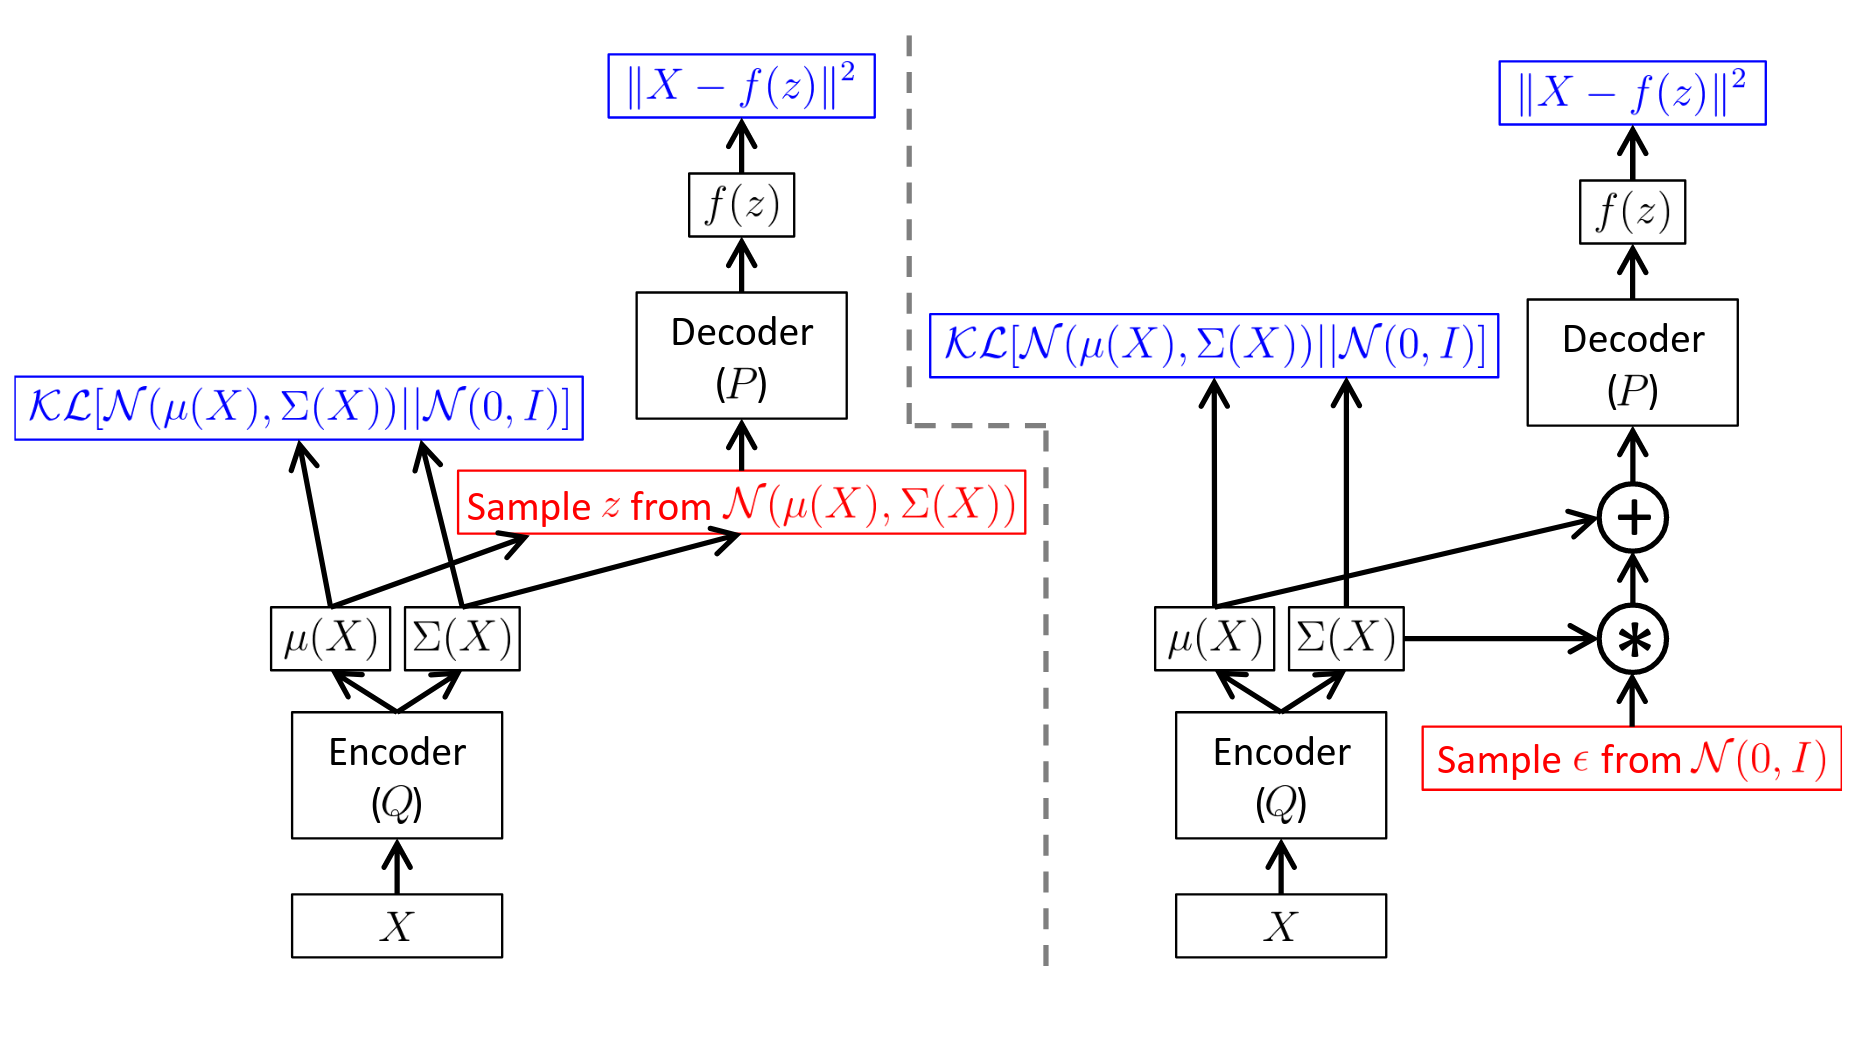
> Left is without the “reparameterization trick”, and right is with it. Red shows sampling operations that are non-differentiable. Blue shows loss layers. The feedforward behavior of these networks is identical, but backpropagation can be applied only to the right network.



In [7]:
# VAE model
class VAE(nn.Module):
    def __init__(self, h_dim, z_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, h_dim)
        self.fc_mu = nn.Linear(h_dim, z_dim)
        self.fc_logvar = nn.Linear(h_dim, z_dim)
        self.fc_dec1 = nn.Linear(z_dim, h_dim)
        self.fc_dec2 = nn.Linear(h_dim, 28*28)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc_dec1(z))
        return torch.sigmoid(self.fc_dec2(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return x_hat, mu, log_var

# Hyper-parameters
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

model = VAE(h_dim=h_dim, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Here for the loss, instead of MSE for the reconstruction loss, we take Binary Cross-Entropy (you should sum the loss over all pixels and samples, not average!)

The KL divergence can be computed as:

$$-\frac{1}{2} \sum_{j=1}^J\left(1+\log(\sigma_j^2) - \mu_j^2 -\sigma_j^2\right)$$

see Appendix B in VAE paper or (Doersch, 2016, https://arxiv.org/abs/1606.05908)

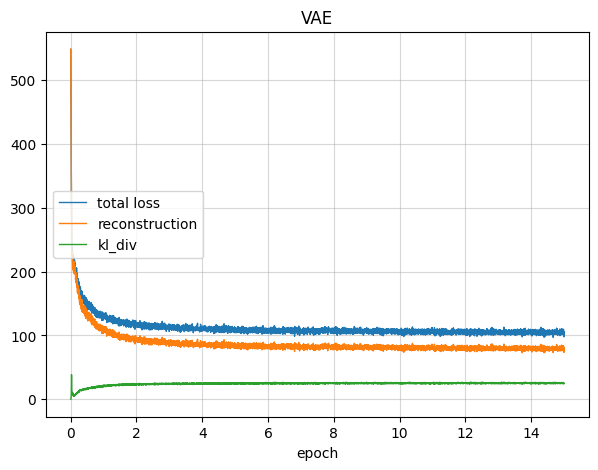

In [8]:
verbose = False
IMAGE_SIZE = 28 * 28  # défini globalement pour lisibilité

data_dict = { "epoch": [], "total loss": [], "reconstruction": [], "kl_div": [] }

for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1, IMAGE_SIZE)
        x_reconst, mu, log_var = model(x)

        # Compute reconstruction loss and KL divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = reconst_loss + kl_div

        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Bookkeeping
        data_dict["total loss"].append(loss.item() / len(x))
        data_dict["reconstruction"].append(reconst_loss.item() / len(x))
        data_dict["kl_div"].append(kl_div.item() / len(x))
        data_dict["epoch"].append(epoch + float(1+i) / len(data_loader))

        # Logging
        if (i+1) % 100 == 0:
            if verbose:
                print("Epoch [{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                      .format(epoch+1, num_epochs, i+1, len(data_loader),
                              reconst_loss.item()/len(x), kl_div.item()/len(x)))
            else:
                live_plot(data_dict, x_key="epoch", title="VAE")

live_plot(data_dict, x_key="epoch", title="VAE")

L’évolution des courbes d’apprentissage montre que l'entraînement du VAE s'est déroulé correctement. On observe une forte diminution des pertes totales et de reconstruction au début, indiquant que le modèle apprend rapidement à reproduire les images d’entrée. À partir de l’epoch 3 environ, les courbes se stabilisent et convergent progressivement vers un plateau. Cela suggère que le modèle atteint un optimum local raisonnable, sans divergence ni oscillation. La divergence de Kullback-Leibler (KL div), quant à elle, démarre proche de zéro puis augmente doucement pour se stabiliser également. Cela montre que la régularisation de l’espace latent s’impose progressivement : au début, le modèle génère des variables latentes proches de la moyenne, puis il apprend une meilleure distribution. Le compromis entre fidélité de reconstruction et régularité du code latent semble donc équilibré. Aucun surapprentissage évident n’est visible.

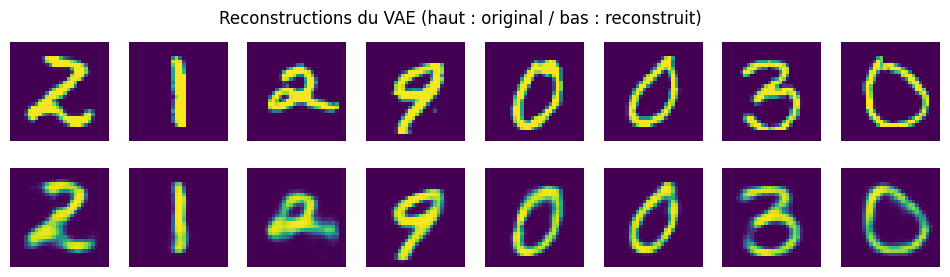

In [ ]:
model.eval()  # mode évaluation

with torch.no_grad():
    x, _ = next(iter(data_loader))
    x = x.to(device)
    x_flat = x.view(-1, 28*28)
    x_reconst, _, _ = model(x_flat)
    x_reconst = x_reconst.view(-1, 1, 28, 28).cpu()

# Affichage côte à côte : original (haut), reconstruction (bas)
n = 8  # nombre d'exemples à afficher
plt.figure(figsize=(12, 3))
for i in range(n):
    plt.subplot(2, n, i + 1)
    show(x[i].cpu())  # original
    plt.axis('off')
    plt.subplot(2, n, i + 1 + n)
    show(x_reconst[i])
    plt.axis('off')
plt.suptitle("Reconstructions du VAE (haut : original / bas : reconstruit)")
plt.show()

## A.3 - Evaluating results

Let us see how our network reconstructs our last batch. We display pairs of original digits and reconstructed version side by side.

Observe how most reconstructed digits are essentially identical to the original version.
This means that the identity mapping has been learned well.
You should still see some blurry digits very different from the original (resample a couple times if needed).

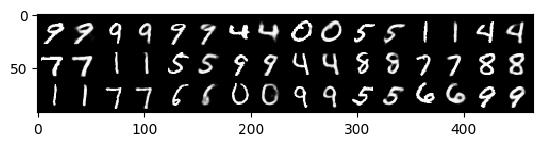

In [10]:
plot_reconstruction(model)

Let's see now how our network generates new samples.

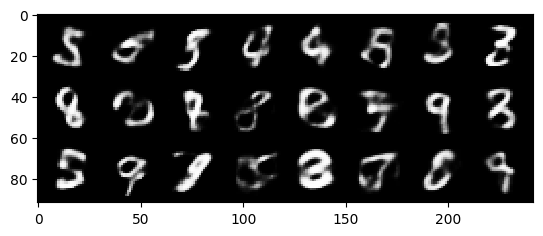

In [22]:
plot_generation(model)

Not great, but we did not train our network for long... That being said, we have no control of the generated digits. In the rest of this notebook, we explore ways to generates zeroes, ones, twos and so on.


As a by-product, we show how our VAE will allow us to do clustering thanks to the Gumbel VAE described below. But before that, we start by cheating a little bit...

# Part B - Cheating with the "conditional" VAE

We would like to generate samples of a given number. We have so far a model for images $X \in [0,1]^{P}$ with $P = 784$ pixels, generated as $X = f_\theta(Z)$ where $Z \sim \mathcal{N}(0,I)$ is a latent with normal distribution. In other to sample a specific digit, we will use a model
$g_\theta : \mathbb{R}^z \times \{0,\ldots,9\} \to [0,1]^P$ and sample images according to $X = g_\theta(Z, Y)$
where $Y \in \{0, \ldots, 9\}$ is a class label.

In the context of variational autoencoding, this is considered cheating,
because it uses external information (the class label) instead of learning the modes from the data.

To build the function $g$, we will simply concatenate the latent representation with
a one-hot encoding of the class. This way, we can use the above architecture with very little modification.

First, write a function transforming a label into its onehot encoding. This function will be used in the training loop (not in the architecture of the neural network!).

In [27]:
def l_2_onehot(labels, nb_digits=N_CLASSES):
    # Convertit les labels en vecteurs one-hot
    batch_size = labels.size(0)
    one_hot = torch.zeros(batch_size, nb_digits, device=labels.device)
    one_hot.scatter_(1, labels.view(-1, 1), 1)
    return one_hot

You can test it on a batch.

In [23]:
(x,labels) = next(iter(data_loader))

In [24]:
labels

tensor([3, 1, 4, 0, 1, 1, 4, 8, 9, 0, 3, 8, 5, 8, 7, 1, 0, 1, 3, 6, 9, 6, 6, 9,
        3, 1, 8, 8, 8, 6, 4, 0, 7, 3, 8, 1, 6, 0, 0, 4, 3, 1, 3, 4, 0, 2, 4, 1,
        8, 9, 1, 4, 9, 0, 3, 0, 6, 7, 9, 0, 3, 7, 0, 7, 9, 7, 2, 2, 7, 5, 8, 9,
        1, 1, 3, 2, 9, 9, 7, 1, 3, 7, 9, 7, 1, 9, 5, 4, 9, 3, 3, 8, 6, 4, 9, 1,
        3, 9, 9, 5, 2, 3, 6, 3, 7, 4, 6, 2, 6, 1, 7, 4, 2, 4, 3, 2, 2, 8, 7, 8,
        8, 3, 2, 0, 9, 3, 6, 7])

In [28]:
assert l_2_onehot(labels).shape == (*labels.shape, N_CLASSES)
l_2_onehot(labels)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

Now modify the architecture of the VAE where the decoder takes as input the random code concatenated with the onehot encoding of the label, you can use `torch.cat`.

In [29]:
class VAE_Cond(nn.Module):
    def __init__(self, h_dim, z_dim):
        super(VAE_Cond, self).__init__()
        self.z_dim = z_dim

        # Encodeur : x (784) + y_onehot (10) → h → mu/logvar
        self.fc1 = nn.Linear(28*28 + N_CLASSES, h_dim)
        self.fc_mu = nn.Linear(h_dim, z_dim)
        self.fc_logvar = nn.Linear(h_dim, z_dim)

        # Décodeur : z (latent) + y_onehot → h → x reconstruit
        self.fc3 = nn.Linear(z_dim + N_CLASSES, h_dim)
        self.fc4 = nn.Linear(h_dim, 28*28)

    def encode(self, x, l_onehot):
        x = torch.cat([x, l_onehot], dim=1)  # concatène x et labels
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, l_onehot):
        z = torch.cat([z, l_onehot], dim=1)  # concatène z et labels
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x, l_onehot):
        x = x.view(-1, 28*28)  # flatten
        mu, log_var = self.encode(x, l_onehot)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z, l_onehot)
        return x_hat, mu, log_var

Test your new model on a batch:

In [30]:
model_C = VAE_Cond(h_dim=h_dim, z_dim=z_dim).to(device)
x = x.to(device).view(-1, IMAGE_SIZE)
l_onehot = l_2_onehot(labels).to(device)
x_reconst, mu, log_var = model_C(x, l_onehot)
assert x_reconst.shape == x.shape
assert mu.shape == log_var.shape and mu.shape == (x.shape[0], z_dim)
x_reconst.shape, mu.shape, log_var.shape

(torch.Size([128, 784]), torch.Size([128, 20]), torch.Size([128, 20]))

Now you can modify the training loop of your network. 

Also, scale the KL term in your loss with $\beta$ to strengthen the regularization as explained in the [$\beta$-VAE paper](https://openreview.net/forum?id=Sy2fzU9gl) see formula (4) in the paper.

In [31]:
def train_C(model, data_loader=data_loader, num_epochs=num_epochs, beta=10., verbose=True):
    nmi_scores = []
    model.train(True)
    data_dict = { "epoch": [], "total loss": [], "reconstruction": [], "kl_div": [] }
    title = "Conditional VAE"

    for epoch in range(num_epochs):
        for i, (x, labels) in enumerate(data_loader):
            x = x.to(device).view(-1, IMAGE_SIZE)
            l_onehot = l_2_onehot(labels).to(device)

            # Forward pass
            x_reconst, mu, log_var = model(x, l_onehot)

            # Compute losses
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = reconst_loss + beta * kl_div

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Bookkeeping
            data_dict["total loss"].append(loss.item() / len(x))
            data_dict["reconstruction"].append(reconst_loss.item() / len(x))
            data_dict["kl_div"].append(kl_div.item() / len(x))
            data_dict["epoch"].append(epoch + float(1+i) / len(data_loader))

            # Logging
            if (i+1) % 100 == 0:
                if verbose:
                    print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                          .format(epoch+1, num_epochs, i+1, len(data_loader),
                                  reconst_loss.item()/len(x),
                                  kl_div.item()/len(x)))
                else:
                    live_plot(data_dict, x_key="epoch", title=title)

    live_plot(data_dict, x_key="epoch", title=title)

In [32]:
model_C = VAE_Cond(h_dim=h_dim, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model_C.parameters(), lr=learning_rate)

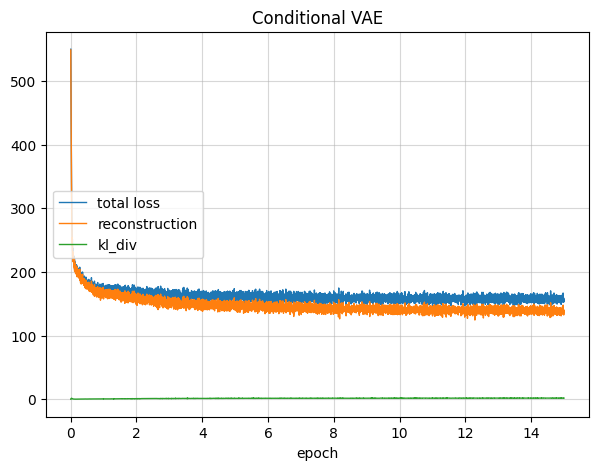

In [33]:
train_C(model_C, num_epochs=15, verbose=False)

Le modèle conditionnel converge bien. La perte totale et la perte de reconstruction diminuent rapidement au début puis se stabilisent vers l’epoch 5, ce qui montre un bon apprentissage. Le terme KL reste très faible malgré le facteur β=10, indiquant que la régularisation est bien contrôlée mais que le modèle reste proche d’un autoencodeur classique. Cela peut venir soit d’un déséquilibre entre les deux termes, soit d’un latent trop contraint. Le modèle apprend tout de même efficacement à reconstruire les images en tenant compte des labels.

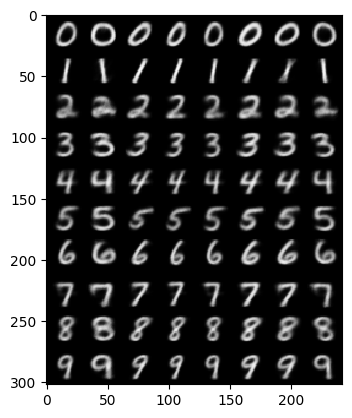

In [34]:
plot_conditional_generation(model_C)

Here you should get nice results. Now we will avoid the use of the labels...

# Part C - No cheating with Gumbel VAE

Implement a VAE where you add a categorical variable $c\in \{0,\dots 9\}$ so that your latent variable model is $p(c,z,x) = p(c)p(z)p_{\theta}(x|c,z)$ and your variational posterior is $q_{\phi}(c|x)q_{\phi}(z|x)$ as described in this NeurIPS paper: [(Dupont, 2018)](https://arxiv.org/abs/1804.00104). Try to make only minimal modifications to previous architecture.

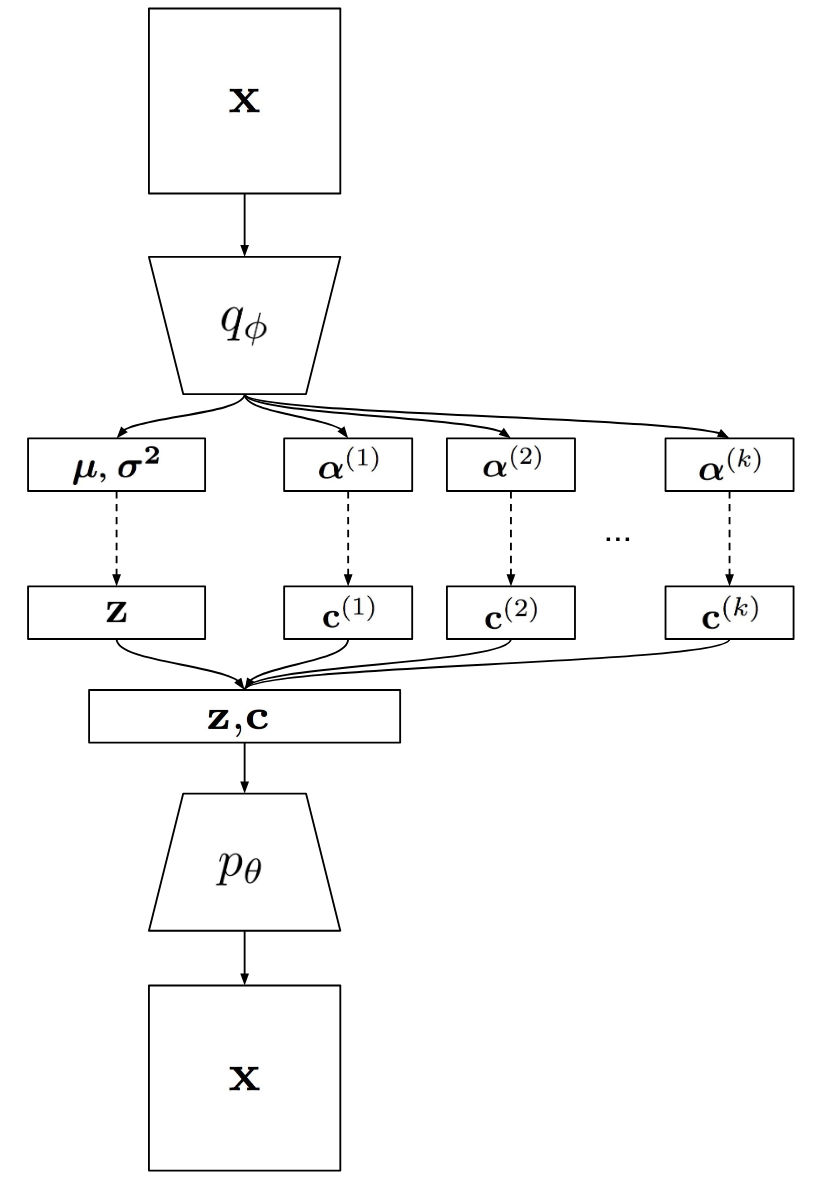

The idea is to incorporate a categorical variable in your latent space, without cheating by forcing it to take the value of the image's label. You hope that this categorical variable will encode the class of the digit, so that your network can use it for a better reconstruction, but can't force it. Moreover, if things work as planned, you will then be able to generate digits conditionally to the class, i.e. you can choose the class thanks to the latent categorical variable $c$ and then generate digits from this class.

## C.1 - Gumbel trick for discrete latent variables

As noticed above, in order to sample random variables while still being able to use backpropagation, we need to use the reparameterization trick which is easy for Gaussian random variables. For categorical random variables, the reparameterization trick is explained in [(Jang et al., 2016)](https://arxiv.org/abs/1611.01144). This is implemented in PyTorch thanks to [F.gumbel_softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.gumbel_softmax.html).

Note: there is an instability in the PyTorch `F.gumbel_softmax` implementation. We provide instead `gumbel_softmax` which takes the same arguments and ensures that the output is not NaN. If you encounter nans in your training or errors in the binary cross-entropy, make sure you are using the stabilized version.

Note: `gumbel_softmax` expects log-probabilities as input. See https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html

In [59]:
def gumbel_softmax(logits, tau=1, hard=False, eps=1e-10, dim=-1):
    def stabilized_gumbel():
        gumbels = - torch.empty_like(logits).exponential_().log()
        reject = torch.isnan(gumbels).sum() or torch.isinf(gumbels).sum()
        return stabilized_gumbel() if reject else gumbels

    gumbels = stabilized_gumbel()
    gumbels = (logits + gumbels) / tau
    y_soft = gumbels.softmax(dim)

    if hard:
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(logits).scatter_(dim, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        ret = y_soft
    return ret

class VAE_Gumbel(nn.Module):
    def __init__(self, h_dim, z_dim):
        super(VAE_Gumbel, self).__init__()
        self.z_dim = z_dim

        self.fc1 = nn.Linear(28*28, h_dim)
        self.fc_logits = nn.Linear(h_dim, z_dim)

        self.fc_dec1 = nn.Linear(z_dim + N_CLASSES, h_dim)
        self.fc_dec2 = nn.Linear(h_dim, 28*28)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        logits = self.fc_logits(h)
        return logits  # pas mu/logvar ici, juste logits pour gumbel softmax

    def decode(self, z, y_onehot):
        z_cat = torch.cat([z, y_onehot], dim=1)
        h = F.relu(self.fc_dec1(z_cat))
        return torch.sigmoid(self.fc_dec2(h))

    def forward(self, x, y_onehot=None, tau=1.0, hard=False):
        x = x.view(-1, 28*28)
        logits = self.encode(x)
        z = gumbel_softmax(logits, tau=tau, hard=hard)
        
        if y_onehot is None:
            raise ValueError("y_onehot must be provided for decoding in conditional VAE_Gumbel.")
        
        x_reconst = self.decode(z, y_onehot)
        return x_reconst, z, logits

In [60]:
model_G = VAE_Gumbel(h_dim=h_dim, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

You need to modify the loss to take into account the categorical random variable with an uniform prior on $\{0,\dots 9\}$, see Appendix A.2 in [(Dupont, 2018)](https://arxiv.org/abs/1804.00104).

Note this can be implemented by taking the entropy of $c$

In [63]:
def train_G(model, data_loader=data_loader, num_epochs=num_epochs, beta=1., verbose=True):
    nmi_scores = []
    model.train(True)
    data_dict = { "epoch": [], "total loss": [], "reconstruction": [], "kl_div": [], "entropy": [] }
    title = "Gumbel VAE"

    for epoch in range(num_epochs):
        for i, (x, labels) in enumerate(data_loader):
            x = x.to(device).view(-1, IMAGE_SIZE)
            l_onehot = l_2_onehot(labels).to(device)

            # Forward pass
            x_reconst, z, logits = model(x, y_onehot=l_onehot, tau=1.0, hard=False)

            # Losses
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')

            # KL divergence: categorical with uniform prior = -entropy - log(K)
            log_q = torch.log(z + 1e-10)  # pour stabiliser log(0)
            H_cat = - torch.sum(z * log_q)  # entropie
            kl_div = -H_cat - z.size(0) * torch.log(torch.tensor(z.size(1), dtype=torch.float, device=z.device))
            loss = reconst_loss + beta * kl_div

            # Backprop and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Bookkeeping
            data_dict["total loss"].append(loss.item() / len(x))
            data_dict["reconstruction"].append(reconst_loss.item() / len(x))
            data_dict["kl_div"].append(kl_div.item() / len(x))
            data_dict["entropy"].append(H_cat.item() / len(x))
            data_dict["epoch"].append(epoch + float(1+i) / len(data_loader))

            if (i+1) % 100 == 0:
                if verbose:
                    print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Entropy: {:.4f}"
                          .format(epoch+1, num_epochs, i+1, len(data_loader),
                                  reconst_loss.item()/len(x),
                                  kl_div.item()/len(x),
                                  H_cat.item()/len(x)))
                else:
                    live_plot(data_dict, x_key="epoch", title=title)

    live_plot(data_dict, x_key="epoch", title=title)


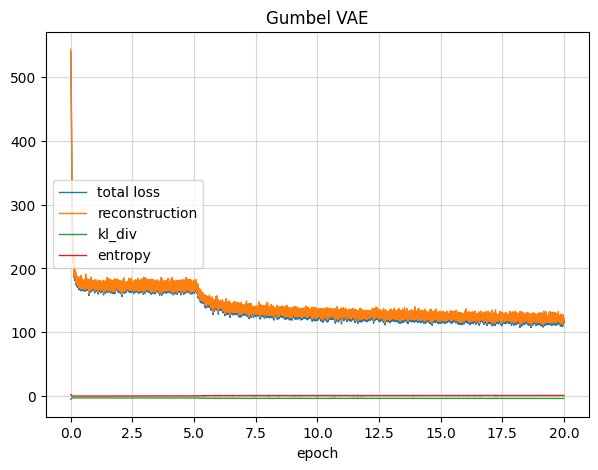

In [64]:
train_G(model_G, num_epochs=20, verbose=False)

L’apprentissage du Gumbel VAE est stable et montre une convergence progressive. La perte de reconstruction chute rapidement au début puis décroît plus lentement après un palier visible autour de l’époque 6. La perte totale suit une tendance similaire, ce qui confirme que le modèle apprend à générer des reconstructions fidèles. Les termes de KL divergence et d’entropie restent très faibles, ce qui indique que la distribution latente reste proche du prior uniforme, conformément aux attentes du modèle. Cela suggère que le Gumbel VAE parvient à encoder l’information utile dans un espace latent discrétisé, tout en respectant la régularisation imposée.

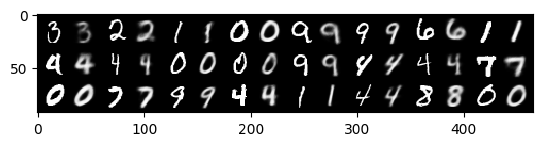

In [65]:
plot_reconstruction(model_G)

The reconstruction is good, but we care more about the generation. For each category, we generate 8 samples thanks to the `plot_conditional_generation()` function.
Consistently with the previous use, each row is supposed to consist of the same digit sampled 8 times, and each row should correspond to a distinct digit.

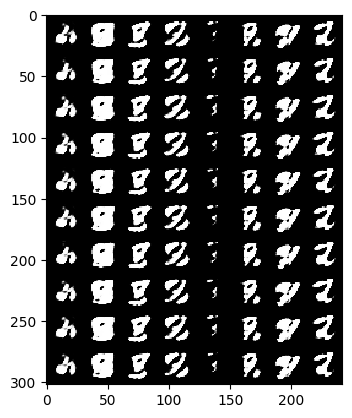

In [66]:
plot_conditional_generation(model_G)

It does not look like our original idea is working...

What is happening is that our network is not using the categorical variable at all (all "digits" look the same, the variation comes from the re-sampling of Z). We can track the [normalized mutual information](https://en.wikipedia.org/wiki/Mutual_information#Normalized_variants) (see [this method in scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html)) between the true labels and the labels predicted by our network (just by taking the category with maximal probability).

Change your training loop to return the normalized mutual information (NMI) for each epoch. Plot the curve to check that the NMI is actually decreasing.

## C.2 - Robust disentangling with controlled capacity increase

This problem is explained in [(Burgess et al., 2018)](https://arxiv.org/abs/1804.03599) and a solution is proposed in Section 5.

In order to force our network to use the categorical variable, we will change the loss according to [(Dupont, 2018)](https://arxiv.org/abs/1804.00104), Section 3 Equation (7).

Implement this change in the training loop and plot the new NMI curve. Increase the $C_z$ and $C_c$ constants by a constant value every epoch until it reaches the value passed in argument.
For $\beta = 20, C_z=100, C_c=100$, you should see that NMI increases.

In [67]:
model_G = VAE_Gumbel(h_dim=h_dim, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

In [68]:
def train_G_modified_loss(model, data_loader=data_loader, num_epochs=num_epochs,
                          beta=1., C_z_fin=0, C_c_fin=0, verbose=True):
    model.train(True)
    data_dict = { "epoch": [], "total loss": [], "reconstruction": [], "kl_div": [], "entropy": [] }
    title = "Gumbel VAE (C2 - capacity constraint)"
    nmi_scores = []

    for epoch in range(num_epochs):
        # Capacity increases linearly
        C_z = min(C_z_fin, C_z_fin * epoch / num_epochs)

        for i, (x, labels) in enumerate(data_loader):
            x = x.to(device).view(-1, IMAGE_SIZE)
            l_onehot = l_2_onehot(labels).to(device)

            # Forward pass
            x_reconst, z, logits = model(x, y_onehot=l_onehot, tau=1.0, hard=False)

            # Reconstruction loss
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')

            # Entropy (same as before)
            log_q = torch.log(z + 1e-10)
            H_cat = - torch.sum(z * log_q)  # entropy
            kl_div = -H_cat - z.size(0) * torch.log(torch.tensor(z.size(1), dtype=torch.float, device=z.device))

            # Modified loss: penalize deviation from target capacity C_z
            loss = reconst_loss + beta * torch.abs(H_cat + z.size(0) * torch.log(torch.tensor(z.size(1), dtype=torch.float, device=z.device)) - C_z)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Bookkeeping
            data_dict["total loss"].append(loss.item() / len(x))
            data_dict["reconstruction"].append(reconst_loss.item() / len(x))
            data_dict["kl_div"].append(kl_div.item() / len(x))
            data_dict["entropy"].append(H_cat.item() / len(x))
            data_dict["epoch"].append(epoch + float(1+i) / len(data_loader))

            if (i+1) % 100 == 0 and verbose:
                print("Epoch[{}/{}], Step[{}/{}], Loss: {:.4f}, H_cat: {:.4f}, C_z: {:.4f}"
                      .format(epoch+1, num_epochs, i+1, len(data_loader),
                              loss.item()/len(x), H_cat.item()/len(x), C_z / len(x)))

    live_plot(data_dict, x_key="epoch", title=title)
    return nmi_scores

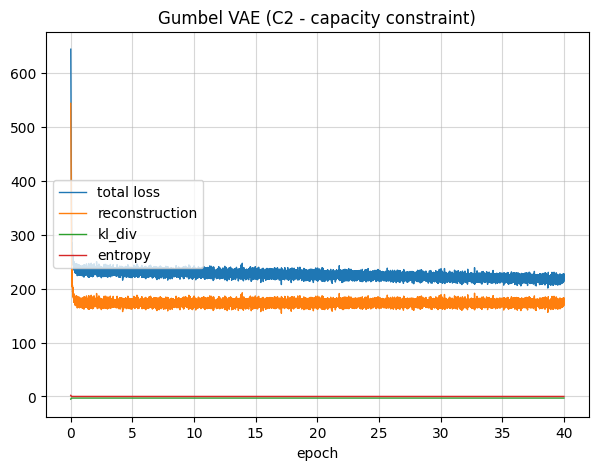

In [69]:
# Hyper-parameters
num_epochs = 40
learning_rate = 1e-3
beta = 20
C_z_fin = 100
C_c_fin = 100

model_G = VAE_Gumbel(h_dim=h_dim, z_dim = z_dim).to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

nmi = train_G_modified_loss(
    model_G, data_loader,
    num_epochs=num_epochs,
    beta=beta,
    C_z_fin=C_z_fin,
    C_c_fin=C_c_fin,
    verbose=False)

Le modèle avec contrainte de capacité apprend de manière stable mais semble plafonner plus tôt. La perte de reconstruction décroît rapidement au début, puis reste presque constante dès l’époque 5, indiquant une saturation rapide de la capacité autorisée par la contrainte 
𝐶
𝑧
C 
z
​
 . La perte totale suit le même comportement, suggérant que le modèle a appris à équilibrer la reconstruction tout en respectant strictement la limite d'entropie. Les courbes de KL divergence et d’entropie sont très faibles et très plates, ce qui confirme que le modèle encode très peu d'information dans le latent. Cela reflète bien l'effet du terme 
∣
𝐻
(
𝑧
)
+
log
⁡
𝐾
−
𝐶
𝑧
∣
∣H(z)+logK−C 
z
​
 ∣ qui impose une contrainte stricte sur la quantité d'information codée.

In [ ]:
plt.plot(nmi)
plt.xlabel("epoch")
plt.ylabel("Normalized Mutual Information")
plt.grid(alpha=.5, which='both')

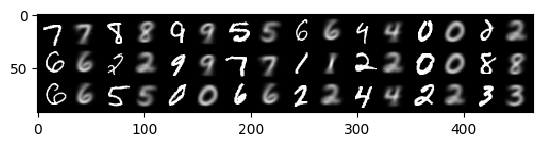

In [70]:
plot_reconstruction(model_G)

La génération conditionnelle est globalement réussie. On observe une bonne diversité de chiffres avec une structure cohérente, et les formes sont bien définies pour la majorité des classes. Certains chiffres (comme les 2, 5, 6 ou 8) montrent une qualité de génération assez nette, tandis que d'autres comme le 3 ou le 4 peuvent apparaître plus flous ou ambigus, indiquant une certaine incertitude dans le modèle. Cela est cohérent avec l'encodage contraint du latent (entropie faible) observé précédemment, qui limite la capacité expressive. Le modèle a donc appris à générer des chiffres reconnaissables mais peu variés à l’intérieur d’une même classe, ce qui correspond bien au fonctionnement d’un Gumbel VAE sous contrainte.

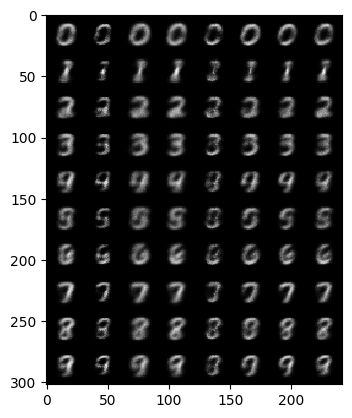

In [71]:
plot_conditional_generation(model_G, fix_number=None)

La génération conditionnelle selon les classes est bien structurée. Chaque ligne correspond visiblement à une classe fixée de chiffre (de 0 à 9), et chaque colonne représente une variation dans l’espace latent (échantillons Gumbel aléatoires). La cohérence horizontale montre que le modèle a bien appris à conditionner la génération sur le label, tandis que la légère variation verticale montre une certaine diversité intra-classe.

La qualité visuelle varie légèrement selon les classes : les 0, 1, 2, 7 ou 9 sont nets et réalistes, tandis que les 4, 5 ou 6 présentent parfois des contours flous ou imprécis, typiques de Gumbel-VAEs avec faible capacité. Cela reste une démonstration convaincante de la capacité du modèle à produire des images fidèles aux classes cibles, tout en respectant la contrainte de discrétisation latente.

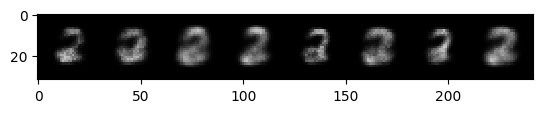

In [72]:
plot_conditional_generation(model_G, fix_number=2)

Cette visualisation montre une interpolation dans l’espace latent du Gumbel VAE, conditionnée sur le chiffre 2. L’évolution progressive de l’image d’un extrême à l’autre illustre bien la continuité perceptuelle apprise malgré un espace latent discret.

Les images intermédiaires conservent globalement l’identité du chiffre, mais présentent une déformation progressive : certaines variantes deviennent plus arrondies, d'autres plus effilées ou tordues. Cela indique que le modèle capture une variabilité réaliste intra-classe tout en restant dans le support du chiffre cible.

Ce comportement est une caractéristique attendue d’un bon VAE (même discret) : naviguer dans le latent génère des transitions sémantiquement fluides.

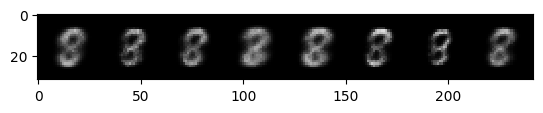

In [73]:
plot_conditional_generation(model_G, fix_number=8)

Cette deuxième interpolation, centrée sur le chiffre 8, confirme la cohérence structurelle de l’espace latent appris par le Gumbel VAE. Le modèle génère une progression fluide entre deux représentations du chiffre 8, en maintenant une forme identifiable sur toute la séquence. Les variations portent principalement sur l’épaisseur des traits et l’ouverture des boucles, ce qui montre que le modèle encode des facteurs de variation internes à la classe, malgré l'utilisation d'une distribution discrète.

Ce type de résultat est caractéristique d’un latent bien organisé : chaque échantillon reste dans le manifold de la classe cible, sans dériver vers d’autres digits.

## C.3 - Interpretation of learned results

Compare the generated digits from the Conditional VAE model and the modified Gumbel-VAE.
The conditional VAE produces all digits in order, which makes for a nice picture; on the other hand, the Gumbel VAE has no way of knowing the order of digits, it must just guess modes of pictures that look the same, so the order is meaningless.
Note however the variations of straight/inclined ones, are they present on the same row ?
What about shapes from the same row morphing from one digit to another, does it make sense that this was a considered a single mode by the model ? Are there distinct modes corresponding to the same digit, and if so, is it a reasonable distinction ?

In [ ]:
plot_conditional_generation(model_C, fix_number=None)

In [ ]:
plot_conditional_generation(model_G, fix_number=None)

---